In [12]:
import transformers
from accelerate import init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM

[2023-07-23 08:51:14,837] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [13]:
from utils.add_argument import add_argument
import argparse
import deepspeed
import json

parser = argparse.ArgumentParser(description="MFMds")
parser.add_argument(
    "--dataset-name", type=str, default="PM6-Full-3D", help="dataset name"
)
parser.add_argument(
    "--data_path", type=str, default="./dataset", help="path to dataset"
)
parser.add_argument(
    "--loadcheck_path", type=str, default="", help="path to dataset"
)
parser.add_argument(
    "-b",
    "--batch_size",
    default=1024,
    type=int,
    help="mini-batch size (default: 32)",
)
parser.add_argument(
    "-e",
    "--epochs",
    default=100,
    type=int,
    help="number of total epochs (default: 50)",W
)
parser.add_argument(
    "--local_rank",
    type=int,
    default=-1,
    help="local rank passed from distributed launcher",
)
parser.add_argument(
    "--global_rank",
    type=int,
    default=-1,
    help="global rank passed from distributed launcher",
)
parser.add_argument(
    "--backend", type=str, default="nccl", help="distributed backend"
)
parser.add_argument("--seed", type=int, default=666666, help="PRNG seed")
parser.add_argument("--node_rank", type=int, default=-1)
parser.add_argument("--rank", type=int, default=-1)
parser.add_argument("--num-classes", type=int, default=1, help="number of classes")
parser.add_argument(
    "--encoder_embed_dim", type=int, default=768, help="encoder embedding dimension"
)
parser.add_argument("--encoder_ffn_embed_dim", type=int, default=768, help="")
parser.add_argument(
    "--llm_hidden_size", type=int, default=4096, help="encoder embedding dimension"
)
parser.add_argument("--llm_ffn_size", type=int, default=256, help="")
parser.add_argument("--encoder_attention_heads", type=int, default=32, help="")
parser.add_argument("--encoder_layers", type=int, default=24, help="")
parser.add_argument("--max-nodes", type=int, default=8, help="")
parser.add_argument("--add-3d", default=False, action="store_true", help="")
parser.add_argument("--no-2d", default=False, action="store_true", help="")
parser.add_argument("--num-3d-bias-kernel", type=int, default=128, help="")
parser.add_argument("--num_pred_attn_layer", type=int, default=4, help="")
parser.add_argument("--droppath_prob", type=float, default=0.0, help="")
parser.add_argument("--attn_dropout", type=float, default=0.1, help="")
parser.add_argument("--act_dropout", type=float, default=0.1, help="")
parser.add_argument("--dropout", type=float, default=0.0, help="")
parser.add_argument("--weight_decay", type=float, default=0.0, help="")
parser.add_argument("--sandwich_ln", default=True, action="store_true", help="")
parser.add_argument("--infer", action="store_true", default=False, help="")
parser.add_argument("--noise_scale", type=float, default=0.2, help="")
parser.add_argument("--mask_ratio", type=float, default=0.3, help="")
parser.add_argument("--log-interval", type=int, default=100, help="log per n steps")
parser.add_argument(
    "--pipeline_parallelism", type=int, default=0, help="log per n steps"
)
parser.add_argument("--steps", type=int, default=10000000, help="log per n steps")
parser.add_argument(
    "--output_path", type=str, default="/blob/output", help="log per n steps"
)
parser.add_argument(
    "--d_tilde", type=float, default=1, help="mu transfer multiplier"
)
parser.add_argument("--max_lr", type=float, default=1e-3, help="max lr")
parser.add_argument(
    "--total_num_steps",
    type=int,
    default=1000000,
)
parser.add_argument("--warmup_num_steps", type=int, default=60000)

parser.add_argument(
    "--smiles_dict_path",
    type=str,
    default="/home/peiran/FMproj/moleculenet_data/data/mol2idx_dict.jsonl",
)
parser.add_argument(
    "--llm_model_name_or_path",
    type=str,
    default="/home/peiran/FMproj/MetaLLM-converted",
)
parser.add_argument(
    "--loadmfmcheck_path",
    type=str,
    default="/home/peiran/FMproj/DiffTM100M/checkpoint7.pt",
)
parser.add_argument(
    "--loadllmcheck_path", type=str, default="/home/peiran/FMproj/MetaLLM-converted"
)
parser.add_argument(
    "--dataset_names", type=str, default="hiv,clintox,sider,tox21,bbbp,bace"
)
parser.add_argument("--dataset_ratios", type=str, default="")
parser.add_argument("--dataset_splits", type=str, default="")
parser.add_argument("--mol2idx_dict_path", type=str, default="")
parser.add_argument("--in_memory", type=bool, default=False)
parser.add_argument("--mol_size_path", type=str, default="")
parser.add_argument("--pool_mode", type=str, default="qformer")
parser.add_argument("--embedding_length", type=int, default=20)
parser.add_argument("--btn_adaptor", type=bool, default=False)
parser.add_argument("--mfm_lora", type=bool, default=False)
parser.add_argument("--model_max_length", type=int, default=2048)

parser = deepspeed.add_config_arguments(parser)
args, unknown = parser.parse_known_args()

global_step = "global_step10000"


In [14]:
from tqdm import tqdm
import torch


total_size = 0
index_map = {"weight_map": {}}
model_states2 = {}
for i in range(37):
    ckpt_path = "/home/peiran/FMproj/output/" + global_step + f"/layer_{i:02d}-model_states.pt"
    model_states = torch.load(ckpt_path, map_location='cpu')
    # print(ckpt_path)
    all_keys = list(model_states.keys())

    for key in all_keys:
        if key.find('lora') != -1:
            continue
        if key.find("dummy") != -1:
            continue
        if key.find("partial_learnable_emb") != -1:
            continue
        
        weight = model_states.pop(key)
        key = key.replace("base_model.model.", "")

        if i == 0:
            key = "graphormer_encoder." + key
        elif i <= 2:
            if key.startswith("embed_tokens.weight"):
                key = "decoder.model." + key
            else:
                key = "adaptor." + key
        elif i < 35:
            key = "decoder.model.layers.{}.".format(i-3) + key
        elif i == 35:
            key = "decoder.model." + key
        elif i == 36:
            key = "decoder." + key

        # index_map["weight_map"][key] = f"layer_{i:02d}-model_states.bin"
        model_states2[key] = weight
        total_size += weight.nelement() * weight.element_size()
        index_map["weight_map"][key] = f"graphormerllama.bin"
    del model_states

    # torch.save(model_states2, "/home/peiran/FMproj/output/" + global_step + f"/layer_{i:02d}-model_states.bin")
torch.save(model_states2, "/home/peiran/FMproj/output/" + global_step + f"/graphormerllama.bin")
del model_states2
index_map["total_size"] = total_size

with open("/home/peiran/FMproj/output/" +  global_step + "/graphormerlamma.bin.index.json", "w") as out_file:
    json.dump(index_map, out_file)

In [15]:
from transformers import LlamaForCausalLM
from models.generalist.graphormer_llama import GraphormerLlamaModel

args.llm_model_name_or_path = "/home/peiran/FMproj/MetaLLM-converted/7B_insft"
args.ft = True

with init_empty_weights():
    model = GraphormerLlamaModel(args, vocab_size=32011)
    # model = LlamaForCausalLM.from_pretrained(args.llm_model_name_or_path)

names = []
for name, parameter in model.named_parameters():
    names.append(name)
# print(names)

json.dump(names, open("/home/peiran/FMproj/output/" + global_step + "/graphormerlamma.json", "w"))

INFO:FoundationModel:Namespace(dataset_name='PM6-Full-3D', data_path='./dataset', loadcheck_path='', batch_size=1024, epochs=100, local_rank=-1, global_rank=-1, backend='nccl', seed=666666, node_rank=-1, rank=-1, num_classes=1, encoder_embed_dim=768, encoder_ffn_embed_dim=768, llm_hidden_size=4096, llm_ffn_size=256, encoder_attention_heads=32, encoder_layers=24, max_nodes=8, add_3d=False, no_2d=False, num_3d_bias_kernel=128, num_pred_attn_layer=4, droppath_prob=0.0, attn_dropout=0.1, act_dropout=0.1, dropout=0.0, weight_decay=0.0, sandwich_ln=True, infer=False, noise_scale=0.2, mask_ratio=0.3, log_interval=100, pipeline_parallelism=0, steps=10000000, output_path='/blob/output', d_tilde=1, max_lr=0.001, total_num_steps=1000000, warmup_num_steps=60000, smiles_dict_path='/home/peiran/FMproj/moleculenet_data/data/mol2idx_dict.jsonl', llm_model_name_or_path='/home/peiran/FMproj/MetaLLM-converted/7B_insft', loadmfmcheck_path='/home/peiran/FMproj/DiffTM100M/checkpoint7.pt', loadllmcheck_path=

In [16]:
from accelerate import load_checkpoint_and_dispatch, infer_auto_device_map, dispatch_model, load_checkpoint_in_model

device_map = infer_auto_device_map(
    model, 
    no_split_module_classes=["LlamaDecoderLayer", "GraphormerSentenceEncoderLayer"],
    dtype='float16'
)
# print(device_map)
full_model_device_map = {k: 0 for k, v in device_map.items()}

# model = load_checkpoint_in_model(
#     model, "/home/peiran/FMproj/output/" + global_step, device_map=device_mpa, dtype='float16', offload_state_dict=True 
# )

# model.decoder.tie_weights()

model = load_checkpoint_and_dispatch(
    model, 
    "/home/peiran/FMproj/output/" + global_step, 
    device_map=full_model_device_map, 
    no_split_module_classes=["LlamaDecoderLayer", "GraphormerSentenceEncoderLayer"],
    offload_state_dict = True, 
    offload_buffers = True, 
    dtype='float16'
)

# full_model_device_map = {f"model.{k}": v for k, v in device_map.items()}
# full_model_device_map["lm_head"] = 0
# dispatch_model(model, device_map=full_model_device_map)

print(model.decoder.model.embed_tokens.weight.shape)
print(model.decoder.lm_head.weight.shape)
# model.eval()

torch.Size([32011, 4096])
torch.Size([32011, 4096])


In [17]:
from data.mol_data.tokenizer import MolTokenizer
from utils.move_to_device import move_to_device
args.llm_model_name_or_path = "/home/peiran/FMproj/MetaLLM-converted/7B_insft"

tokenizer = MolTokenizer(args)

# batched_smile_data = move_to_device(batched_smile_data, 'cuda:1')
# model.decoder.tie_weights()


In [41]:
# text = ["#Prompt: The smile of the molecule is <mol> c1ccc(C2CN=C3NCCN32)cc1 </mol>, give its description"]
# text = ["### Instruction: \nWhat can you tell me about this molecule?\n  ###Input: <mol> CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1 </mol> ### Response:\n"]
# text = ["### Instruction:\nWhat can you tell me about this molecule?\n  ###Input: <mol> c1ccc(C2CN=C3NCCN32)cc1 </mol> ### Response:\n"]
# text = ["### Instruction: \nIs this molecule toxic?\n  ###Input: <mol> CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1 </mol> ### Response:\n"]
# text = ["### Instruction:\nIs this molecule able to penetrate blood-brain barrier?\n  ###Input: <mol> CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1 </mol> ### Response:\n"]
text = ["### Instruction:\nProvide a brief overview of this molecule.\n ###Input: <mol> CC(=O)C </mol> ### Response:\n"]

# text = ["To fix a broken audio device in my laptop"]
input_ids, batched_smile_data, llm_mask = tokenizer.tokenize(text)
print(input_ids)
input_ids = input_ids.to('cuda:0')
llm_mask = llm_mask.to('cuda:0')
res = model.generate(batched_smile_data, input_ids=input_ids, attention_mask=llm_mask, do_sample=True, temperature=0.7, max_new_tokens=256, output_scores=True, return_dict_in_generate=True)
# print(res.sequences[0])
print(text)
res = tokenizer.text_tokenizer.decode(res.sequences[0], skip_special_tokens=False)
print(res)

tensor([[    1,   835,  2799,  4080, 29901,    13,  1184, 29894,   680,   263,
         11473,   975,  1493,   310,   445, 13206, 29883,  1297, 29889,    13,
           835,  4290, 29901, 32001,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1, 32002,   835, 13291, 29901,    13]])
['### Instruction:\nProvide a brief overview of this molecule.\n ###Input: <mol> CC(=O)C </mol> ### Response:\n']
<s> The chlorogenic acid in coffee is an antioxidant. It is found in green and unroasted coffee beans. It is also found in the roasted beans. The ratio of chlorogenic acid in green and roasted coffee beans is 15.7 times higher in green beans than in roasted beans. However, the level of chlorogenic acid decreases after roasting. The level of chlorogenic acid becomes insignificant after roasting. The antioxidants in coffee are chlorogenic acid, caffeic acid, ferulic acid, and p-coumaric acid. 

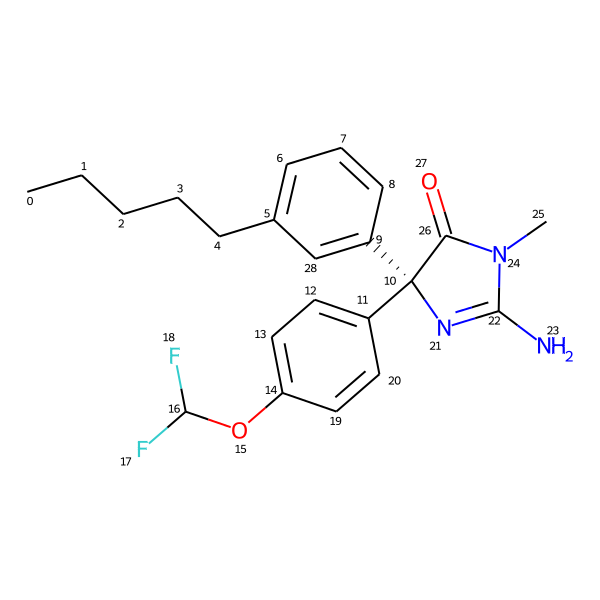

In [11]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600,600

mol = Chem.MolFromSmiles("CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1")
mol

# def mol_with_atom_index(mol):
#     for atom in mol.GetAtoms():
#         atom.SetAtomMapNum(atom.GetIdx())
#     return mol
# mol_with_atom_index(mol)
